# Topic Modeling of the American Presidential Inaugarations dataset with LDA

## Set up

### Install necessary packages

In [1]:
# pip install --upgrade opendatasets numpy pandas scipy scikit-learn matplotlib seaborn gensim wordcloud

### Import packages

In [2]:
import os
import numpy as np
import pandas as pd
import gensim as gm
import seaborn as sns
import opendatasets as od
import regex as re
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt
from wordcloud import WordCloud as wc

### Download Data
For this step, we need the `kaggle` api which was installed above. Please follow these instructions:
1. Create a kaggle account
2. Navigate to https://kaggle.com/`username`/account -> `API` -> `Create New API Token` 
3. Move the downloaded `kaggle.json` file to `~/.kaggle/` using a command such as `mv ~/Downloads/kaggle.json ~/.kaggle/` from the CLI or using your machine's gui`
4. Open the kaggle.json you should see something like `{"username":"[USERNAME]","key":"[KEY]"}`. Copy `KEY` to your clipboard
5. Run the command below and follow the prompts
6. Done! You should see `inaug_speeches.csv` in `./data` dir.

In [3]:
# os.makedirs('../data',exist_ok=True)
# od.download('https://www.kaggle.com/datasets/adhok93/presidentialaddress',data_dir='../data',force=True)
# os.rename('../data/presidentialaddress/inaug_speeches.csv','../data/inaug_speeches.csv')
# os.rmdir('../data/presidentialaddress')

### Helper Functions

In [4]:
def word2topic(word_topic_probs,words,n_terms=5):
    n_topics = len(word_topic_probs)
    words = {ind:word for word,ind in words.items()}
    top_k_inds = np.argsort(word_topic_probs,axis=-1)
    top_k_inds = top_k_inds[:,-1*n_terms:]
    top_k_inds = top_k_inds[::-1]
    # top_k_inds = np.flip(top_k_inds,axis=-1)
    terms={i:[] for i in range(len(word_topic_probs))}
    for i in range(len(word_topic_probs)):
         for j in range(len(top_k_inds[i,:])):
            ind = top_k_inds[i,j]
            terms[i].append(words[ind])
    return terms
def topics2docs(doc_topic_probs,n_topics=3):
    top_k_inds = np.argsort(doc_topic_probs,axis=-1)
    top_k_inds = top_k_inds[:,-1*n_topics:]
    top_k_inds = top_k_inds[::-1]
    topics = {i:top_k_inds[i,:] for i in range(len(doc_topic_probs))}
    return topics
def label_data(date,by='Era'):
    US_ERAS={0:(1783,1815),1:(1815,1861),2:(1861,1877),3:(1877,1900),4:(1900,1929),5:(1929,1945),6:(1945,1968),7:(1968,2022)}
    year = date.split(',')[-1]
    year = int(year)
    for era,length in US_ERAS.items():
        if year >= length[0] and year < length[1]:
            return era
    return -1
def word_count(speeches):
    wc = {}
    for word in set([word for speech in speeches for word in speech.split()]):
        for speech in speeches:
            if word in speech:
                if word not in wc:
                    wc[word] = 0
                else:
                    wc[word] += 1
    for word in wc.keys():
        wc[word] = wc[word]/len(speeches)
    return wc

In [5]:
def preprocess(speeches_df):
    speeches_df = speeches_df.drop(columns=list(speeches_df.keys())[0])
    speeches_df['Inaugural Address'] = speeches_df['Inaugural Address'].apply(lambda x: 1 if x == 'Inaugural Address' or 'first' in x else 2)
    speeches_df['text'] = speeches_df['text'].apply(lambda x: re.sub(r'<.*?>', '', x))
    speeches_df['text'] = speeches_df['text'].apply(lambda x: x.strip('\t')).apply(lambda x: x.strip('\n'))
    speeches_df['text'] = speeches_df['text'].apply(lambda x: x.strip('\t')).apply(lambda x: x.replace(u'\xa0',''))
    speeches_df['Era'] = [label_data(date) for date in speeches_df['Date']]
    speeches = speeches_df['text'].to_list()
    tfidf = TfidfVectorizer(input='content',stop_words='english',max_df=0.95,min_df=0.01)
    X = tfidf.fit_transform(speeches)
    words = tfidf.vocabulary_
    return speeches_df,X,tfidf,words


## LDA on Presidential Inaugural Addresses Dataset

### Data Exploration

#### Load Data

In [6]:
speeches_df_raw = pd.read_csv('../data/inaug_speeches.csv',encoding='latin1')
speeches_df_raw.head()

,Unnamed: 0,Name,Inaugural Address,Date,text
0,4,George Washington,First Inaugural Address,"Thursday, April 30, 1789",Fellow-Citizens of the Senate and o...
1,5,George Washington,Second Inaugural Address,"Monday, March 4, 1793",Fellow Citizens: I AM again cal...
2,6,John Adams,Inaugural Address,"Saturday, March 4, 1797","WHEN it was first perceived, in ..."
3,7,Thomas Jefferson,First Inaugural Address,"Wednesday, March 4, 1801",Friends and Fellow-Citizens: CA...
4,8,Thomas Jefferson,Second Inaugural Address,"Monday, March 4, 1805","PROCEEDING, fellow-citizens, to ..."


In [7]:
print('Basic statistics about raw data:')
print(f'Number of Speeches (data points): {len(speeches_df_raw)}')
print(f'Total number of unique words before filtering: {len(set([word for speech in speeches_df_raw.text.tolist() for word in speech.split()]))}')
print(f'Average word length before filtering: {np.mean([len(word) for word in set([word for speech in speeches_df_raw.text.tolist() for word in speech.split()])])}')
print(f'Average speech length before filtering: {int(np.round(np.mean(speeches_df_raw.text.apply(lambda x:len(x)))))}')

Basic statistics about raw data:
Number of Speeches (data points): 58
Total number of unique words before filtering: 15087
Average word length before filtering: 8.260621727314907
Average speech length before filtering: 13819


#### Filter/preprocess data

In [8]:
speeches_df,X,tfidf,words = preprocess(speeches_df_raw)
speeches_df.head()

,Name,Inaugural Address,Date,text,Era
0,George Washington,2,"Thursday, April 30, 1789",Fellow-Citizens of the Senate and o...,0
1,George Washington,2,"Monday, March 4, 1793",Fellow Citizens: I AM again calle...,0
2,John Adams,1,"Saturday, March 4, 1797","WHEN it was first perceived, in ea...",0
3,Thomas Jefferson,2,"Wednesday, March 4, 1801",Friends and Fellow-Citizens: CALL...,0
4,Thomas Jefferson,2,"Monday, March 4, 1805","PROCEEDING, fellow-citizens, to th...",0


In [9]:
print('Basic statistics about filtered data:')
print(f'Number of Speeches (data points): {len(speeches_df_raw)}')
print(f'Total number of unique words after filtering: {len(words)}')
print(f'Average word length before filtering: {np.mean([len(word) for word in words])}')
print(f'Average speech length after filtering: {int(np.round(np.mean(speeches_df.text.apply(lambda x:len(x)))))}')

Basic statistics about filtered data:
Number of Speeches (data points): 58
Total number of unique words after filtering: 9256
Average word length before filtering: 8.005509939498703
Average speech length after filtering: 13685


#### Visualize Data

Text(0.5, 1.0, 'Top 100 words in Presidential Inaugural Addresses')

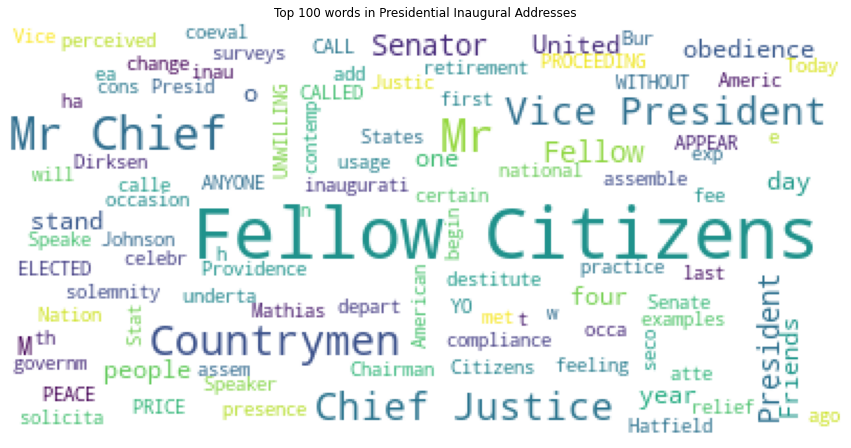

In [10]:
fig,axs = plt.subplots(1,figsize=(15,15))
axs.imshow(wc(background_color='white',max_words=100).generate(str(speeches_df['text'])))
axs.axis('off')
axs.set_title('Top 100 words in Presidential Inaugural Addresses')

### Perform LDA on dataset

#### Get $P(T|D),P(T|W)$

In [11]:
N_TOPICS = 20
print(f'Number of topics to be found: {N_TOPICS}')
lda = LDA(n_components=N_TOPICS)
logits = lda.fit_transform(X)
logits.shape,lda.components_.shape

Number of topics to be found: 20


((58, 20), (20, 9256))

#### Get top $N$ terms occuring in each of the $T$ topics

In [12]:
N_TERMS = 5
topic_words = word2topic(lda.components_,words,n_terms=N_TERMS)
print(f'Top {N_TERMS} words occuring in each of the {N_TOPICS} topics')
for topic,terms in topic_words.items():
    print(f'Topic {topic}: {terms}')

Top 5 words occuring in each of the 20 topics
Topic 0: ['artificial', 'represents', 'stands', 'strives', 'speaks']
Topic 1: ['proportion', 'inculcate', 'anarchy', 'clause', 'constitutionally']
Topic 2: ['repose', 'belligerent', 'salutary', 'faculties', 'texas']
Topic 3: ['auxiliaries', 'disturbed', 'counteraction', 'hardly', 'regarded']
Topic 4: ['defamation', 'budget', 'song', 'whatsoever', 'nuclear']
Topic 5: ['learned', 'industrial', 'build', 'peoples', 'live']
Topic 6: ['slaves', 'offense', 'wills', 'offenses', 'woe']
Topic 7: ['task', 'action', 'things', 'republic', 'old']
Topic 8: ['entangling', 'intolerance', 'retire', 'thousandth', 'impartially']
Topic 9: ['creation', 'safeguard', 'physical', 'sum', 'territorial']
Topic 10: ['futurewill', 'flexible', 'doors', 'bridge', 'worlds']
Topic 11: ['willingly', 'violated', 'incurring', 'upbraidings', 'arrive']
Topic 12: ['evidently', 'foreboding', 'unequaled', 'designed', 'occasionally']
Topic 13: ['dispute', 'door', 'relationship', 'br

#### Get top $20\%$ of topics assigned to each document

In [13]:
N_TOPICS_PER_DOC=5
print(f'Top {N_TOPICS_PER_DOC} topics appearing in each of the {X.shape[0]} documents')
topic_docs = topics2docs(logits,N_TOPICS_PER_DOC)

for doc,topics in topic_docs.items():
    topics = ', '.join([str(topic) for topic in topics])
    name = speeches_df.iloc[doc]['Name']
    ia = speeches_df.iloc[doc]['Inaugural Address']
    print(f'{name}\'s Inaugural Address #{ia}: {topics}')

Top 5 topics appearing in each of the 58 documents
George Washington's Inaugural Address #2: 6, 1, 14, 3, 12
George Washington's Inaugural Address #2: 17, 14, 12, 1, 3
John Adams's Inaugural Address #1: 1, 14, 12, 8, 3
Thomas Jefferson's Inaugural Address #2: 1, 14, 12, 2, 3
Thomas Jefferson's Inaugural Address #2: 13, 14, 12, 1, 3
James Madison's Inaugural Address #2: 1, 14, 12, 9, 3
James Madison's Inaugural Address #2: 8, 1, 14, 12, 3
James Monroe's Inaugural Address #2: 1, 14, 12, 6, 3
James Monroe's Inaugural Address #2: 1, 14, 12, 15, 3
John Quincy Adams's Inaugural Address #1: 6, 1, 14, 12, 3
Andrew Jackson's Inaugural Address #2: 8, 12, 14, 1, 3
Andrew Jackson's Inaugural Address #2: 13, 1, 12, 14, 3
Martin Van Buren's Inaugural Address #1: 5, 8, 14, 3, 12
William Henry Harrison's Inaugural Address #1: 13, 14, 12, 5, 3
James Knox Polk's Inaugural Address #1: 13, 1, 14, 12, 3
Zachary Taylor's Inaugural Address #1: 18, 14, 12, 19, 3
Franklin Pierce's Inaugural Address #1: 1, 14, 

#### Visualize Topic Clusterings with *t-SNE*

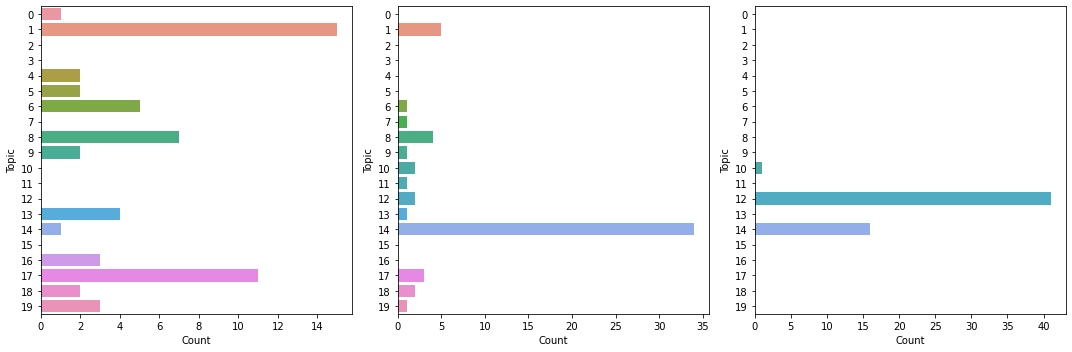

In [14]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
for i in range(3):
    count = {k:0 for k in range(N_TOPICS)}
    for j in [topics[i] for topics in topic_docs.values()]:
        count[j] += 1
    count = pd.DataFrame(count.values(),columns=['Count'])
    count['Topic'] = np.arange(len(count))
    sns.barplot(count,x='Count',y='Topic',orient='horizontal',ax=axs[i])
fig.tight_layout()

In [ ]:
clusters = TSNE(n_components = 2).fit_transform(logits)
plt.scatter(clusters[:,0],clusters[:,1],c = [topic[0] for topic in topic_docs.values()])

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
